In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import json
import os

from analysis import plot, process # imoporting analysis module enables import from model folder
import analysis.pipelines.population_spikes as ps

%matplotlib inline

RESULT_PATH = "simulation_results"
OUTPUT_PATH = "analysis_results"
overwrite = False

pop_color = plot.pop_color

In [2]:
ps.set_variables(RESULT_PATH=RESULT_PATH, OUTPUT_PATH=OUTPUT_PATH)

PN_pop_names = ps.PN_pop_names
ITN_pop_names = ps.ITN_pop_names

In [3]:
# Processing parameters
max_lag = 300. # ms. maximum time lag for cross-correlation
method = 'wavelet'  # method to obtain wave amplitude
normalize_lfp = True  # whether normalize LFP wave amplitude by RMS of LFP
normalize_fr = False  # whether normalize FR wave amplitude by magnitude of FR

# normalize_lfp = 'wavelet' # normalize LFP wave amplitude by amplitude estimated from wavelet transform scalogram
# normalize_fr = 'wavelet' # normalize FR wave amplitude by amplitude estimated from wavelet transform scalogram
# ps.XCORR_PATH = os.path.join(OUTPUT_PATH, 'wave_fr_xcorr_wavelet_normalized')


wave_lines = {'gamma': ':', 'beta': '--'}
waves = list(wave_lines)

wave_kwargs = {
    'filter': dict(
        waves = {'gamma': (30.0, 44.0), 'beta': (14.5, 23.5)},
        transform = process.wave_hilbert,
        filt_order = 4
    ),
    'wavelet': dict(
        waves = {'gamma': 37.0, 'beta': 19.0},
        transform = process.wave_cwt,
        bandwidth = 2.0  # time band (inverse to frequency band), sigma of the gaussian envelope for frequency 1.0
    )
}
wave_kwargs = wave_kwargs[method]

In [4]:
filter = ('rand', 'div')
revert_junction = False
exclude = 'baseline'

with open(os.path.join(OUTPUT_PATH, 'trials_ordered.json'), 'r') as f:
    trials_ordered = json.load(f)
trials = ps.get_trials(filter, trials=trials_ordered, revert_junction=revert_junction, exclude=exclude)
print(trials)

['short_rand', 'short_div', 'long_rand', 'long_div', 'ramp_a0_t0.3_rand', 'ramp_a0_t0.3_div', 'ramp_a0_t1.0_rand', 'ramp_a0_t1.0_div', 'ramp_a0_t1.0_down_rand', 'ramp_a0_t1.0_down_div', 'ramp_a0_t3.0_rand', 'ramp_a0_t3.0_div', 'join_a0_t0.3_rand', 'join_a0_t0.3_div', 'join_a0_t1.0_rand', 'join_a0_t1.0_div', 'join_a0_t1.0_quit_rand', 'join_a0_t1.0_quit_div', 'join_a0_t3.0_rand', 'join_a0_t3.0_div', 'fade_a01_t0.1_rand', 'fade_a01_t0.1_div', 'fade_a03_t0.1_div', 'fade_a01_t0.3_rand', 'fade_a01_t0.3_div', 'fade_a03_t0.3_div', 'fade_a01_t1.0_rand', 'fade_a01_t1.0_div', 'fade_a03_t1.0_div', 'fade_a01_t3.0_rand', 'fade_a01_t3.0_div', 'fade_a03_t3.0_div']


In [5]:
wave_fr_xcorr = [ps.get_wave_fr_xcorr(trial, wave_kwargs=wave_kwargs,
    normalize_lfp=normalize_lfp, normalize_fr=normalize_fr,
    max_lag=max_lag, overwrite=overwrite) for trial in trials]

durations = xr.DataArray([ds.duration for ds in wave_fr_xcorr], coords={'trial': trials})
wave_fr_xcorr = xr.concat(wave_fr_xcorr, dim=pd.Index(trials, name='trial'))
wave_fr_xcorr = wave_fr_xcorr.weighted(durations).mean(dim='trial')

### Cross correlation between oscillation amplitude and ITN firing rates

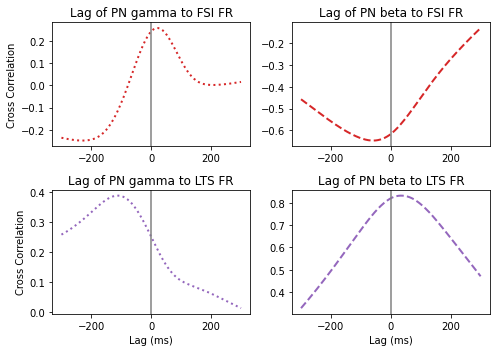

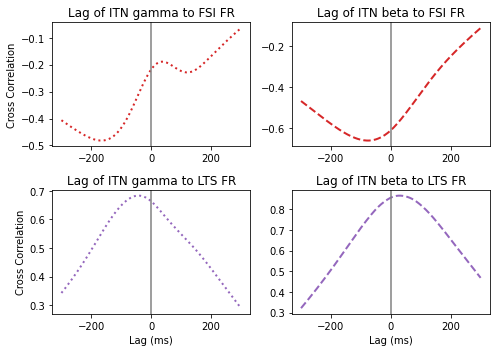

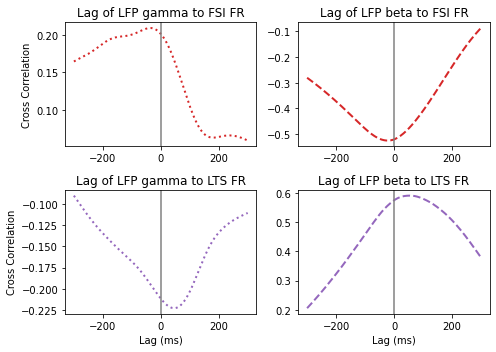

In [6]:
figsize = (3.5, 2.5)
coords = wave_fr_xcorr.coords
n_rows = coords['FR_population'].size
n_cols = coords['wave'].size

for wp in coords['wave_pop'].values:
    _, axs = plt.subplots(n_rows, n_cols, squeeze=False,
                          figsize=(n_cols * figsize[0], n_rows * figsize[1]))
    for i, p in enumerate(coords['FR_population'].values):
        for j, w in enumerate(coords['wave'].values):
            ax = axs[i, j]
            ax.plot(wave_fr_xcorr.lags,
                    wave_fr_xcorr.xcorr.sel(wave_pop=wp, wave=w, FR_population=p),
                    color=pop_color[p], linestyle=wave_lines[w], linewidth=2)
            ax.axvline(0., color='gray')
            ax.set_title(f'Lag of {wp} {w} to {p} FR')
    for ax in axs[-1, :].ravel():
        ax.set_xlabel('Lag (ms)')
    for ax in axs[:, 0].ravel():
        ax.set_ylabel('Cross Correlation')
    plt.tight_layout()

plt.show()

In [7]:
# lags for maximum correlation
display(wave_fr_xcorr.sel(wave_pop='PN', wave='gamma', FR_population='FSI', lags=slice(0, 50)).idxmax())
display(wave_fr_xcorr.sel(wave_pop='PN', wave='beta', FR_population='LTS', lags=slice(0, 50)).idxmax())
display(wave_fr_xcorr.sel(wave_pop='ITN', wave='gamma', FR_population='FSI', lags=slice(0, 50)).idxmax())
display(wave_fr_xcorr.sel(wave_pop='ITN', wave='beta', FR_population='LTS', lags=slice(0, 50)).idxmax())
display(wave_fr_xcorr.sel(wave_pop='LFP', wave='gamma', FR_population='FSI', lags=slice(-50, 50)).idxmax())
display(wave_fr_xcorr.sel(wave_pop='LFP', wave='beta', FR_population='LTS', lags=slice(0, 100)).idxmax())

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    wave_pop       <U3 'PN'
    wave           <U5 'gamma'
    FR_population  <U3 'FSI'
Data variables:
    xcorr          float64 20.0

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    wave_pop       <U3 'PN'
    wave           <U4 'beta'
    FR_population  <U3 'LTS'
Data variables:
    xcorr          float64 35.0

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    wave_pop       <U3 'ITN'
    wave           <U5 'gamma'
    FR_population  <U3 'FSI'
Data variables:
    xcorr          float64 37.5

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    wave_pop       <U3 'ITN'
    wave           <U4 'beta'
    FR_population  <U3 'LTS'
Data variables:
    xcorr          float64 30.0

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    wave_pop       <U3 'LFP'
    wave           <U5 'gamma'
    FR_population  <U3 'FSI'
Data variables:
    xcorr          float64 -35.0

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    wave_pop       <U3 'LFP'
    wave           <U4 'beta'
    FR_population  <U3 'LTS'
Data variables:
    xcorr          float64 55.0